# Allen Cell Types
## Exploratory Data Analysis

### Setup

In [1]:
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
dir_path = os.getcwd()
transgenic_data = pd.read_csv(dir_path + '/data/mouse/ephys_data.csv')
mouse_data = pd.read_csv(dir_path + '/data/mouse/ephys_data.csv')
human_data = pd.read_csv(dir_path + '/data/human/ephys_data.csv')

In [3]:
ctc = CellTypesCache()
cells = ctc.get_cells(species=[CellTypesApi.MOUSE])

### Inspect the electrophysiological response of a neuron according to a stimulus

In [4]:
def get_stimulation_and_response():
    for ind, cell in enumerate(cells):
        cell_id = cell['id']
        data_set = ctc.get_ephys_data(cell_id)
        sweeps = ctc.get_ephys_sweeps(cell_id)
        noise_sweep_number = [x['sweep_number'] for x in sweeps
                              if x['stimulus_name'] in ['Noise 1', 'Noise 2']
                              and x['num_spikes'] is not None
                              and x['num_spikes'] > 10]
        if not noise_sweep_number:
            continue

        try:
            sweep_data = data_set.get_sweep(noise_sweep_number[0])
            return sweep_data
        except:
            continue

In [5]:
def plot_stimulation_and_response(data):
    relevant_signal = range(*data['index_range'])
    stimulation = data['stimulus'][relevant_signal]  # in A
    stimulation *= 1e12  # to pA
    response = data['response'][relevant_signal]  # in V
    response *= 1e3  # to mV

    fig, axes = plt.subplots(2, 1)
    axes[0].plot(np.linspace(0, 9, len(relevant_signal)), stimulation, 'b-', linewidth=0.5, alpha=0.7)
    axes[0].set_xlabel('Seconds')
    axes[0].set_ylabel('pA')
    axes[0].set_title('Stimulation')

    axes[1].plot(np.linspace(0, 9, len(relevant_signal)), response, 'r-', linewidth=0.1, alpha=0.7)
    axes[1].set_xlabel('Seconds')
    axes[1].set_ylabel('mV')
    axes[1].set_ylim([-80, 50])
    axes[1].set_title('Response')

    plt.subplots_adjust(hspace=0.5)
    fig.suptitle('Electrophysiological activity of a neuron')
    plt.show()

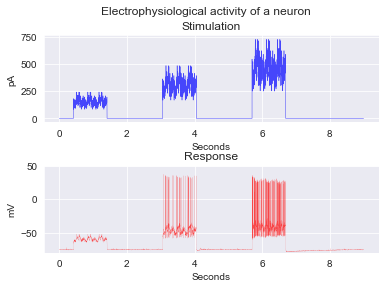

In [6]:
sweep_data = get_stimulation_and_response()
plot_stimulation_and_response(sweep_data)

### What is the distribution of excitatory and inhibitory cells in the data?

In [7]:
def plot_excitatory_inhibitory_distribution():
    fig, axes = plt.subplots(1, 2, sharey='all')
    fig.suptitle('Distribution of inhibitory/excitatory cells')

    axes[0].set_title('Mouse data')
    ax = sns.countplot(ax=axes[0], x="dendrite_type", data=mouse_data, palette="Set2")
    for container in ax.containers:
        ax.bar_label(container)

    axes[1].set_title('Human data')
    ax = sns.countplot(ax=axes[1], x="dendrite_type", data=human_data, palette="Set2")
    for container in ax.containers:
        ax.bar_label(container)

    plt.tight_layout()
    plt.show()

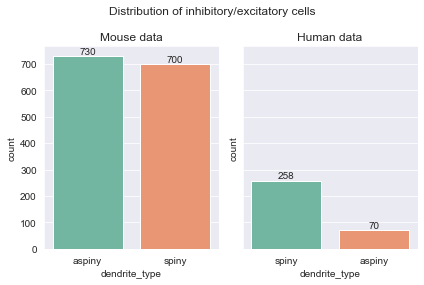

In [8]:
plot_excitatory_inhibitory_distribution()

### What is the distribution of transgenic targeting in the data?

In [9]:
def plot_transgenic_targeting():
    plt.figure()
    plt.title('Distribution of t-types (merged)')
    ax = sns.countplot(x="transgenic_line", data=transgenic_data, palette="Set2",
                       order=transgenic_data['transgenic_line'].value_counts().index)
    for container in ax.containers:
        ax.bar_label(container)
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.draw()

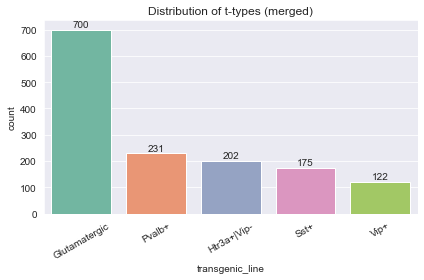

In [10]:
plot_transgenic_targeting()